Google Colab에서 작업한 결과입니다 :)


# 2021-2 Data Analytics Term Project

## Title
다양한 모델을 이용한 농산물 가격 예측 및 성능 비교

## Data
- [Dacon](dacon.io)
- [농산물유통종합정보시스템](nongnet.or.kr)
- [공공데이터 포털](www.data.go.kr)

## Model
LSTM(Long Short-Term Memory, 장단기 메모리)

[참고 블로그) LSTM 이해하기](https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)

In [1]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')

# keras 관련 모듈
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import os

LSTM 주가 예측
https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/

In [8]:
# 데이터 불러오기

path = '/content/MyDrive/MyDrive/2021-2 데이터애널리틱스/'

peppers = pd.read_csv(path+'건고추Model.csv', encoding='cp949', engine='python')
green_onion = pd.read_csv(path+'대파Model.csv', encoding='cp949', engine='python')
garlic = pd.read_csv(path+'마늘Model.csv', encoding='cp949', engine='python')
radish = pd.read_csv(path+'무Model.csv', encoding='cp949', engine='python')
cabbage = pd.read_csv(path+'배추Model.csv', encoding='cp949', engine='python')
peppers.head()

,날짜,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,최대풍속,건고추거래량,건고추생산량,건고추저장이월량,건고추수입량,건고추수입금액,건고추재배면적,고급휘발유,보통휘발유,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가,건고추가격
0,2014-01-23,0.0,0.1,-1.0,7.1,-7.5,62,12,1.3,10.8,5.00,85068,0,97611,285150,36120,2195.24,1884.54,1703.47,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6,5850.000000
1,2014-02-15,0.0,1.0,1.7,8.9,-4.1,62,15,1.6,11.6,5.10,85068,0,97611,285150,36120,2194.28,1879.81,1697.69,1.0,-5.4,1.7,2.5,0.7,0.9,1.7,0.4,5970.441176
2,2014-02-26,4.1,57.8,6.2,11.5,1.2,72,18,1.4,11.5,0.03,85068,0,97611,285150,36120,2202.06,1880.55,1697.69,1.0,-5.4,1.7,2.5,0.7,0.9,1.7,0.4,8734.375000
3,2014-03-04,0.2,26.6,5.1,11.4,-1.1,57,14,1.5,10.3,0.01,85068,0,97611,285150,36120,2203.05,1880.89,1697.46,1.3,-3.1,1.6,2.5,0.6,1.6,2.1,0.8,6000.000000
4,2014-03-06,0.0,0.3,1.4,6.5,-4.1,39,10,2.7,13.3,0.14,85068,0,97611,285150,36120,2202.59,1881.20,1697.44,1.3,-3.1,1.6,2.5,0.6,1.6,2.1,0.8,9611.428571


In [63]:
# window_size만큼 데이터를 잘라 이어붙여주는 함수
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

# prediction/actual 그래프 그리는 함수
def graph(pred, test_label) :
  plt.figure(figsize=(16, 9))
  plt.plot(test_label, label = 'actual')
  plt.plot(pred, label = 'prediction')
  plt.legend()
  plt.show()

# 정규화 및 데이터 분리, 예측하는 함수
def prediction(data, window_size) :
  # 0~1 정규화
  scaler = MinMaxScaler()
  scale_cols = garlic.iloc[:, 3:].columns.tolist()

  scaled = scaler.fit_transform(garlic[scale_cols])
  scaled = pd.DataFrame(scaled)
  scaled.columns = scale_cols

  # train/test 데이터 나누기
  feature_cols = scaled.iloc[:, :26].columns.tolist()
  label_cols = scaled.iloc[:, 26:].columns.tolist()
  print('feature : ', feature_cols, '\nlabel : ', label_cols)

  feature = scaled[feature_cols]
  label = scaled[label_cols]

  # WINDOW_SIZE(과거 며칠간의 데이터를 기반으로 예측할 것인지)만큼 데이터셋 분리
  feature, label = make_dataset(feature, label, window_size)

  X_train, X_test, Y_train, Y_test = train_test_split(feature, label, test_size=0.2)

  print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

  hist = model.fit(X_train, Y_train, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stop, checkpoint])
  model.load_weights(filename)
  pred = model.predict(X_test)
  graph(pred, Y_test)

In [67]:
from keras import backend as K
from tensorflow.keras.optimizers import Adam

# RMSE 값 구하는 함수
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 생성
model = Sequential()
# input_shape(window_size, 변수 개수)
model.add(LSTM(16, input_shape=(7, 26), dropout=0.01, recurrent_dropout=0.01))
model.add(Dense(1))

model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5) # 조기종료 조건
model_path = path+'model/'
filename = os.path.join(model_path, 'checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 16)                2752      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,769
Trainable params: 2,769
Non-trainable params: 0
_________________________________________________________________


feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['마늘가격']
(1713, 7, 26) (1713, 1) (429, 7, 26) (429, 1)
Epoch 1/100
130/137 [===========================>..] - ETA: 0s - loss: 0.1532 - accuracy: 7.6923e-04
Epoch 00001: val_loss improved from inf to 0.12232, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5
137/137 [==============================] - 3s 9ms/step - loss: 0.1512 - accuracy: 7.2993e-04 - val_loss: 0.1223 - val_accuracy: 0.0029
Epoch 2/100
130/137 [===========================>..] - ETA: 0s - loss: 0.1052 - accuracy: 7.6923e-04
Epoch 00002: val_loss improved from 0.12232 to 0.10346, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5
137/137 [==============================] - 1s 6ms/step - loss: 0.1055 - accu

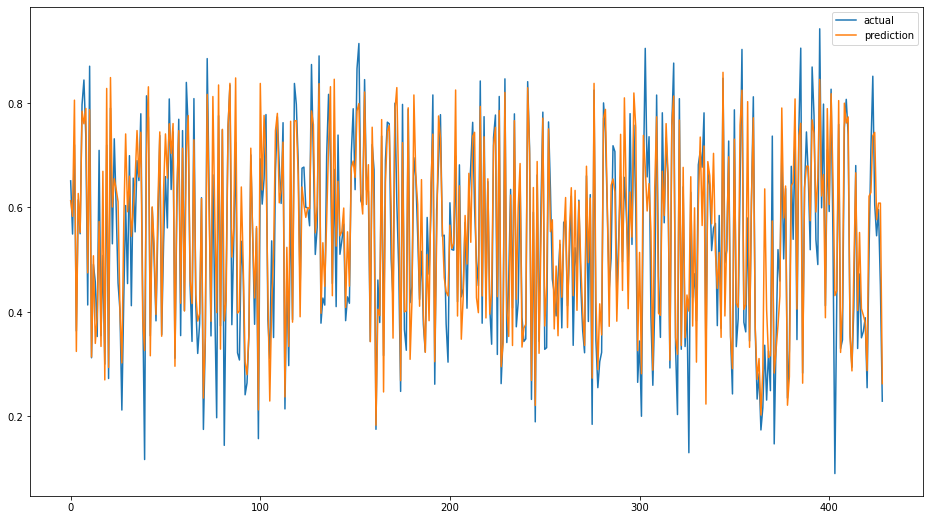

In [68]:
prediction(peppers, 7)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['마늘가격']
(1713, 7, 26) (1713, 1) (429, 7, 26) (429, 1)
Epoch 1/100
133/137 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 7.5188e-04
Epoch 00001: val_loss improved from 0.07903 to 0.07670, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5
137/137 [==============================] - 2s 11ms/step - loss: 0.0804 - accuracy: 7.2993e-04 - val_loss: 0.0767 - val_accuracy: 0.0000e+00
Epoch 2/100
132/137 [===========================>..] - ETA: 0s - loss: 0.0761 - accuracy: 7.5758e-04
Epoch 00002: val_loss improved from 0.07670 to 0.07506, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5
137/137 [==============================] - 1s 7ms/step - loss: 0.07

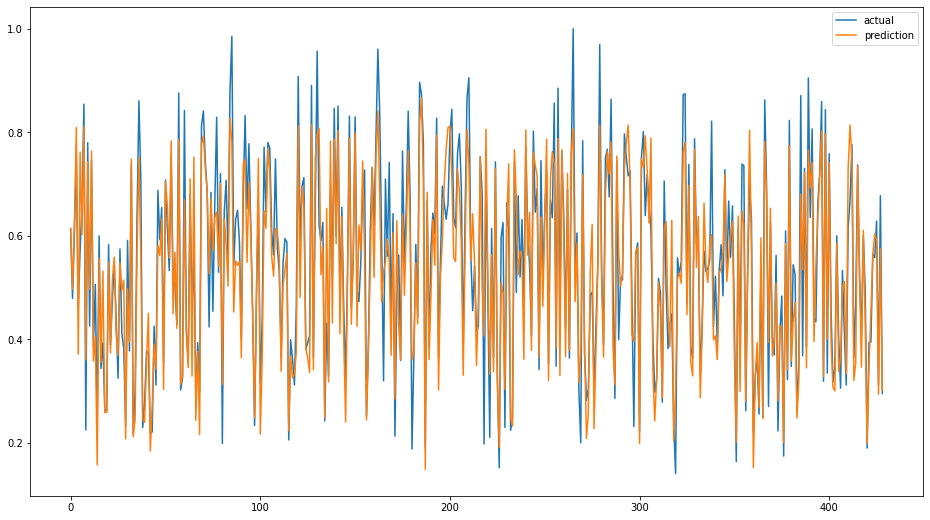

In [69]:
prediction(green_onion, 7)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['마늘가격']
(1713, 7, 26) (1713, 1) (429, 7, 26) (429, 1)
Epoch 1/100
135/137 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.0000e+00
Epoch 00001: val_loss did not improve from 0.07385
137/137 [==============================] - 1s 7ms/step - loss: 0.0764 - accuracy: 0.0000e+00 - val_loss: 0.0752 - val_accuracy: 0.0029
Epoch 2/100
130/137 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.0000e+00
Epoch 00002: val_loss did not improve from 0.07385
137/137 [==============================] - 1s 6ms/step - loss: 0.0761 - accuracy: 0.0000e+00 - val_loss: 0.0831 - val_accuracy: 0.0029
Epoch 3/100
129/137 [===========================>..] - ETA: 0s - loss: 0.0763 - accuracy: 0.0000e+00
Epoch 00003: val_los

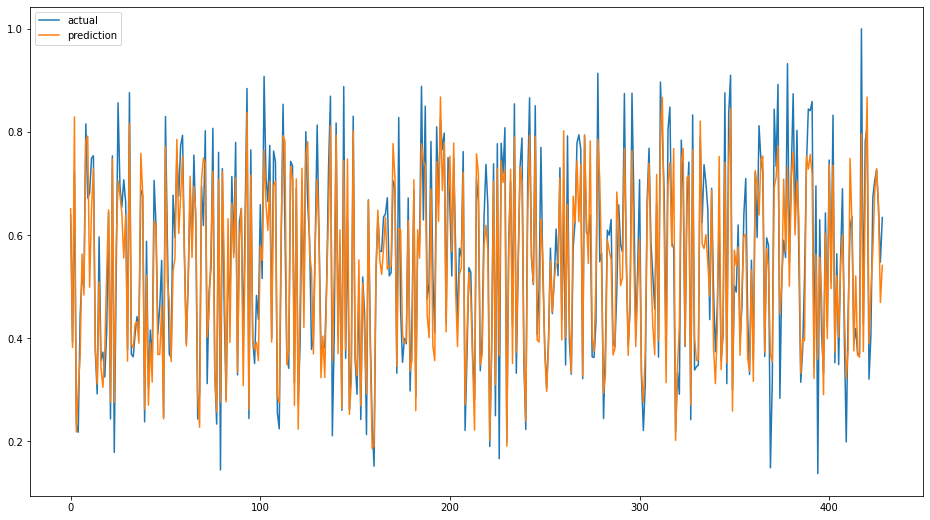

In [70]:
prediction(garlic, 7)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['마늘가격']
(1713, 7, 26) (1713, 1) (429, 7, 26) (429, 1)
Epoch 1/100
134/137 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 7.4627e-04
Epoch 00001: val_loss did not improve from 0.07153
137/137 [==============================] - 1s 7ms/step - loss: 0.0727 - accuracy: 7.2993e-04 - val_loss: 0.0755 - val_accuracy: 0.0000e+00
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 7.2993e-04
Epoch 00002: val_loss did not improve from 0.07153
137/137 [==============================] - 1s 6ms/step - loss: 0.0729 - accuracy: 7.2993e-04 - val_loss: 0.0717 - val_accuracy: 0.0000e+00
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 7.2993e-04
Epoch 00003:

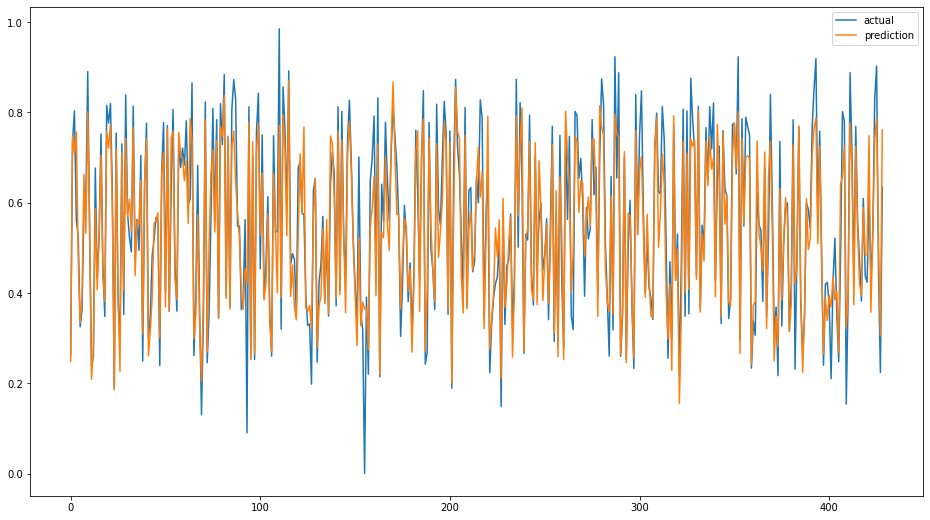

In [71]:
prediction(radish, 7)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['마늘가격']
(1713, 7, 26) (1713, 1) (429, 7, 26) (429, 1)
Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.0000e+00
Epoch 00001: val_loss did not improve from 0.07153
137/137 [==============================] - 1s 7ms/step - loss: 0.0724 - accuracy: 0.0000e+00 - val_loss: 0.0725 - val_accuracy: 0.0058
Epoch 2/100
128/137 [===========================>..] - ETA: 0s - loss: 0.0716 - accuracy: 0.0000e+00
Epoch 00002: val_loss did not improve from 0.07153
137/137 [==============================] - 1s 7ms/step - loss: 0.0715 - accuracy: 0.0000e+00 - val_loss: 0.0720 - val_accuracy: 0.0058
Epoch 3/100
130/137 [===========================>..] - ETA: 0s - loss: 0.0715 - accuracy: 0.0000e+00
Epoch 00003: val_los

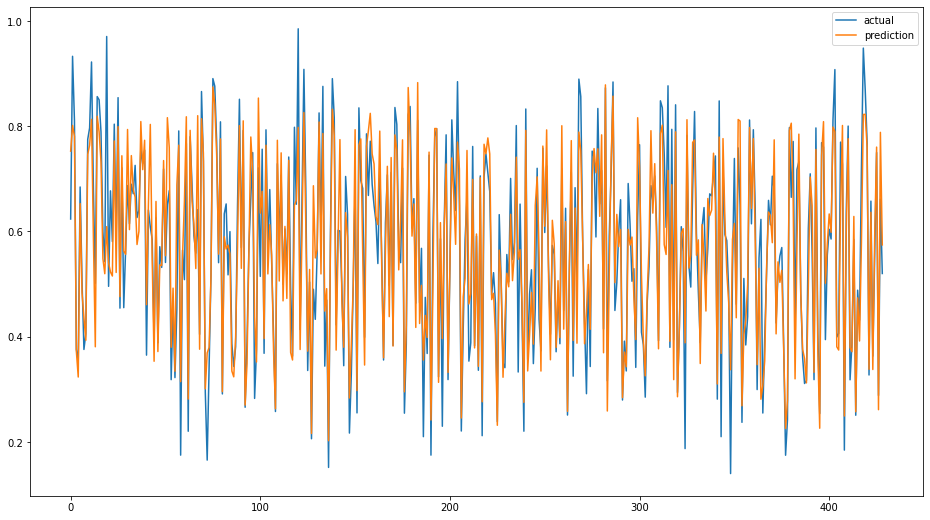

In [72]:
prediction(cabbage, 7)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['마늘가격']
(1702, 21, 26) (1702, 1) (426, 21, 26) (426, 1)
Epoch 1/100
134/137 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 7.4627e-04
Epoch 00001: accuracy improved from -inf to 0.00073, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5
137/137 [==============================] - 6s 24ms/step - loss: 0.1462 - accuracy: 7.3475e-04 - val_loss: 0.1053 - val_accuracy: 0.0000e+00
Epoch 2/100
135/137 [============================>.] - ETA: 0s - loss: 0.1048 - accuracy: 7.4074e-04
Epoch 00002: accuracy did not improve from 0.00073
137/137 [==============================] - 3s 19ms/step - loss: 0.1046 - accuracy: 7.3475e-04 - val_loss: 0.0979 - val_accuracy: 0.0000e+00
Epoch 3/100
136/137 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


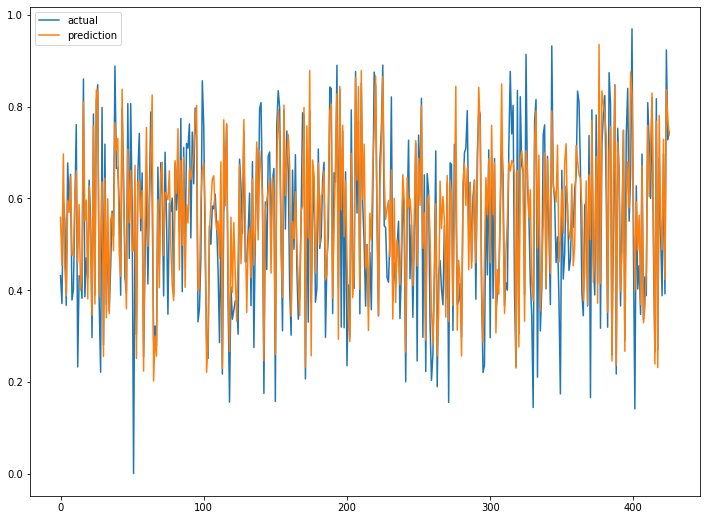

In [58]:
prediction(peppers) # window_size = 21

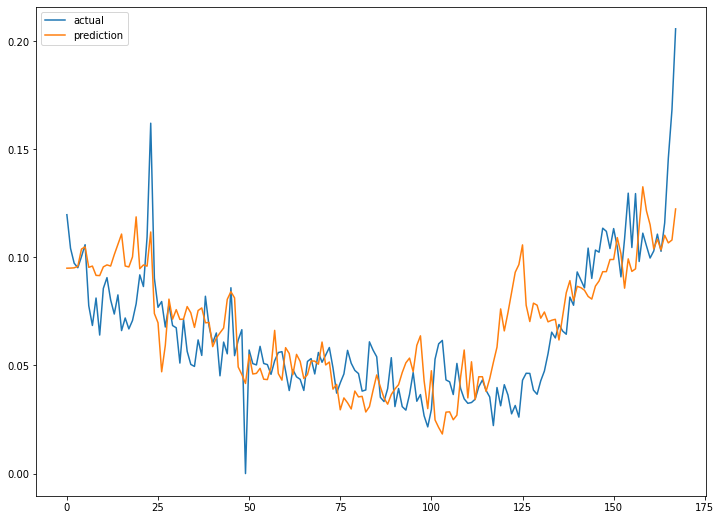